In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pickle
import matplotlib.pyplot as plt
from itertools import cycle

# Tools

In [2]:
def draw_cm(y_test, y_pred, model):
    if model == 'SVM':
        y_true = y_test
        y_pred = y_pred
    else:
        y_true = [item.tolist().index(1) for item in y_test]
        y_pred = [np.argmax(item) for item in y_pred]
    sn.heatmap(confusion_matrix(y_true, y_pred), annot=True)
    plt.title('Confusion Matrix')


def draw_roc(y_test, y_pred, model):
    categories = ["no_tumor", "meningioma_tumor", "glioma_tumor", "pituitary_tumor"]
    fpr, tpr, roc_auc = {}, {}, {}

    if model == 'SVM':
        y_test_temp = np.zeros((len(y_test), len(categories)))
        y_pred_temp = np.zeros((len(y_pred), len(categories)))
        for i, item in enumerate(zip(y_test, y_pred)):
            item_test, item_pred = item[0], item[1]
            y_test_temp[i][item_test] = 1
            y_pred_temp[i][item_pred] = 1
        y_test = y_test_temp
        y_pred = y_pred_temp

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

    if y_test.shape[1] > 2:
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple', 'blue'])
        for i in range(y_test.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, color in zip(range(y_test.shape[1]), colors):
            name = categories[i]
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                              ''.format(name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


def draw_cm_roc(y_test, y_pred, model):
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(121)
    draw_cm(y_test, y_pred, model)

    plt.subplot(122)
    draw_roc(y_test, y_pred, model)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    fig.tight_layout()
    plt.show()

# Data process

In [3]:
def get_feature_label(files, labels, task='binary'):
    categories = ["no_tumor", "meningioma_tumor", "glioma_tumor", "pituitary_tumor"]

    datas, targets = [], []
    for image, label in zip(files, labels):
        img = cv2.imread(image, 0)
        img = cv2.resize(img, dsize=(100, 100), interpolation=cv2.INTER_LINEAR)
        datas.append(img.flatten())

        target = [1, 0]
        if label != 'no_tumor':
            target = [0, 1]

        if task == 'multi':
            target = np.zeros(len(categories))
            target[categories.index(label)] = 1

        targets.append(target)

    datas = np.vstack(datas)
    targets = np.vstack(targets)
    return datas, targets


def get_data(train_csv, test_csv,train_image, test_image, task):
    # train_val files
    data_train_val = pd.read_csv(train_csv)
    names_train_val = data_train_val['file_name'].tolist()
    train_val_labels = data_train_val['label'].tolist()
    train_val_files = [os.path.join(train_image, name) for name in names_train_val]

    ## split train_val into train and val
    train_files = train_val_files[:int(0.8 * len(train_val_files))]
    train_labels = train_val_labels[:int(0.8 * len(train_val_labels))]
    val_files = train_val_files[int(0.8 * len(train_val_files)):]
    val_labels = train_val_labels[int(0.8 * len(train_val_labels)):]

    # test files
    data_test = pd.read_csv(test_csv)
    names_test = data_test['file_name'].tolist()
    test_labels = data_test['label'].tolist()
    test_files = [os.path.join(test_image, name) for name in names_test]

    train_features, train_labels = get_feature_label(train_files, train_labels, task)
    val_features, val_labels = get_feature_label(val_files, val_labels, task)
    test_features, test_labels = get_feature_label(test_files, test_labels, task)

    return train_features, train_labels, val_features, val_labels, test_features, test_labels

# Model

In [4]:
def Classifier(mode='KNN'):
    """make classifier models"""
    clf = KNeighborsClassifier(n_neighbors=5)
    if mode == 'DT':
        clf = DecisionTreeClassifier()
    elif mode == 'RF':
        clf = RandomForestClassifier(n_estimators=100)
    elif mode == 'MLP':
        clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, verbose=True)
    elif mode == 'SVM':
        clf = SVC(kernel='rbf', probability=True)
    return clf

# Train/Test

In [5]:
def main(mode, task, train, verify_part, train_csv, test_csv, train_image, test_image, savePath):
    X_train, y_train, X_val, y_val, X_test, y_test = get_data(train_csv, test_csv, train_image, test_image, task)

    if mode == 'SVM':
        y_train = [item.tolist().index(1) for item in y_train]
        y_val = [item.tolist().index(1) for item in y_val]
        y_test = [item.tolist().index(1) for item in y_test]

    X_verify, y_verify = X_val, y_val
    if verify_part == 'test':
        X_verify, y_verify = X_test, y_test

    if train:
        # train model
        model = Classifier(mode=mode)
        model.fit(X_train, y_train)
        if not os.path.exists(savePath):
            os.makedirs(savePath)
        pickle.dump(model, open(savePath + '/{}_{}.pkl'.format(mode, task), 'wb'))
        print('train done!')

    else:
        # accessment model
        model = pickle.load(open(savePath + '/{}_{}.pkl'.format(mode, task), 'rb'))
        y_pred, y_true = model.predict(X_verify), y_verify

        # draw CM and ROC
        draw_cm_roc(y_true, y_pred, mode)

        # show precision,recall and f1 score
        precision_score = metrics.precision_score(y_true, y_pred, average='macro')
        recall_score = metrics.recall_score(y_true, y_pred, average='macro')
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')
        print('==============precision_score=============')
        print(precision_score)
        print('==============recall_score================')
        print(recall_score)
        print('==============f1_score====================')
        print(f1_score)

In [12]:
train_csv = 'datas/train/label.csv'
train_image = "datas/train/image"
test_csv = 'datas/test/label.csv'
test_image = "datas/test/image"
savePath = 'saved_model'

model = 'SVM'
task = 'multi'
verify_part = 'test'
train = True

main(model, task, train, verify_part, train_csv, test_csv, train_image, test_image, savePath)

train done!


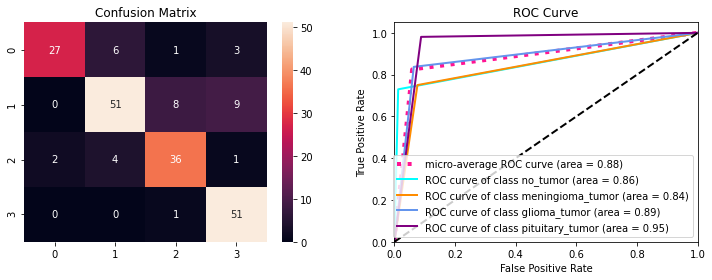

==============precision_score=============
0.8366459380453216
==============recall_score================
0.8244270657061356
==============f1_score====================
0.8242946503682382


In [13]:
model = 'SVM'
task = 'multi'
verify_part = 'test'
train = False

main(model, task, train, verify_part, train_csv, test_csv, train_image, test_image, savePath)